/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Original Prediction: 207


Adversarial Prediction: 208


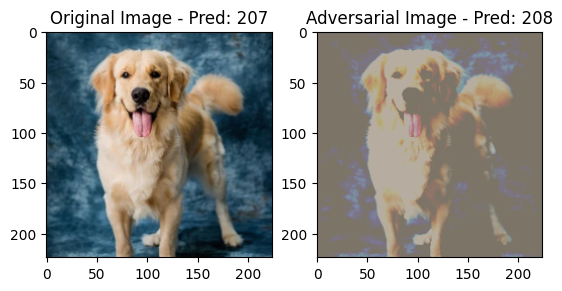

In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt



# Image transformations for pre-trained ResNet model (ImageNet normalization)
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

# Load and preprocess the image
def load_image(image_path):
    image = Image.open(image_path)
    image = preprocess(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# Get model's prediction
def get_prediction(x):
    output = model(x)
    _, pred = torch.max(output, 1)
    return pred.item()

# Loss function: Cross-entropy loss between the target label and the model's prediction
def loss_function(x_adv, x_orig, target_label):
    # Forward pass through the model
    output = model(x_adv)

    # Calculate the classification loss (cross-entropy)
    loss_class = F.cross_entropy(output, target_label)

    # Calculate the perturbation size (L2 norm)
    perturbation_size = torch.norm(x_adv - x_orig)

    # Total loss: classification loss + perturbation size
    loss = loss_class + perturbation_size
    return loss

# Function to generate adversarial example using L-BFGS
def generate_adversarial_example(x_orig, target_label, epsilon=0.1, max_iter=100):
    # Clone the original input to create the adversarial example
    x_adv = x_orig.clone().requires_grad_(True)

    # Define the L-BFGS optimizer
    optimizer = optim.LBFGS([x_adv], max_iter=max_iter, lr=epsilon)
    # Closure function for optimizer
    def closure():
        optimizer.zero_grad()
        loss = loss_function(x_adv, x_orig, target_label)
        loss.backward()
        return loss

    # Perform optimization using L-BFGS
    optimizer.step(closure)

    # Ensure the adversarial example is within valid pixel range
    x_adv = torch.clamp(x_adv, 0, 1)

    return x_adv

# Load an example image and convert it to tensor
image_path = "/content/dog.webp"
x_orig = load_image(image_path)  # Load and preprocess the image

# Print original prediction
original_prediction = get_prediction(x_orig)
print(f"Original Prediction: {original_prediction}")

# Target label for adversarial attack (forcing the model to misclassify as label 3, for example)
target_label = torch.tensor([3])

# Generate the adversarial example
x_adv = generate_adversarial_example(x_orig, target_label)

# Print adversarial prediction
adversarial_prediction = get_prediction(x_adv)
print(f"Adversarial Prediction: {adversarial_prediction}")

# Display the original and adversarial images
x_orig_np = x_orig.squeeze().permute(1, 2, 0).detach().cpu().numpy()
x_adv_np = x_adv.squeeze().permute(1, 2, 0).detach().cpu().numpy()

# Undo normalization for display
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
x_orig_np = std * x_orig_np + mean
x_adv_np = std * x_adv_np + mean

plt.subplot(1, 2, 1)
plt.title(f"Original Image - Pred: {original_prediction}")
plt.imshow(x_orig_np)

plt.subplot(1, 2, 2)
plt.title(f"Adversarial Image - Pred: {adversarial_prediction}")
plt.imshow(x_adv_np)

plt.show()


In [ ]:
import json
import urllib

# Download the ImageNet class index
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
class_idx = urllib.request.urlopen(url)
class_names = [line.strip() for line in class_idx.readlines()]

def get_class_name(class_id):
    return class_names[class_id]

# Example usage:
predicted_class = 208
print(f"Predicted Class: {predicted_class}, Class Name: {get_class_name(predicted_class)}")


Predicted Class: 208, Class Name: b'Labrador retriever'
